# Imports

In [ ]:
# Imports
import numpy as np
import pandas as pd
from math import sqrt
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
import csv
## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
# Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers import Dense, Dropout, Flatten, Layer
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Embedding, Input, dot, concatenate, merge
from keras.models import Model

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df = pd.read_csv("train.csv")

In [ ]:
df.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image,overall
0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,$8.40,p23649501,3856620,NaN,5
1,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,$10.98,p58458313,56086781,NaN,5
2,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,$5.99,p97027626,55852154,NaN,5
3,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,$14.64,p43167086,43228100,NaN,5
4,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,$9.92,p94494236,54425467,NaN,5


# Possibly add time dimension by year?  Slight uptick in rating over time
df['year'] = df['reviewTime'].str[-4:]
df.groupby('year')['overall'].mean()

# Pipeline

In [ ]:
class Pipeline():
    def __init__(self,df):
        self.df = df

    def encode(self, users="reviewerID", items="itemID"):
        self.df['user'] = LabelEncoder().fit_transform(self.df[users])
        self.df['item'] = LabelEncoder().fit_transform(self.df[items])        
    
    def create_matrix(self, users="reviewerID", items="itemID", ratings="overall"):
        self.num_users = self.df[users].nunique()
        self.num_items = self.df[items].nunique()
        self.matrix = np.zeros((self.num_users, self.num_items), dtype=np.int8)
        
        for (index, userID, itemID, rating) in self.df[['user','item',ratings]].itertuples():
            self.matrix[userID-1, itemID-1] = rating

    def get_stop_words(self):
        self.stop = set(stopwords.words('english'))
    
    def getTopKWords(self,kwords,column):
        self.get_stop_words()
        self.counter = Counter()
        text = self.df[column].values
        for t in text:
                self.counter.update(t)
        self.topk = self.counter.most_common(kwords)

    def tokenize(self,column):
        self.df[column] = self.df[column].fillna("")
        self.df[column+'_tokens'] = self.df[column].apply(lambda x:[token.lower() for token in re.findall(r'\w+',x) if token.lower() not in self.stop and len(token) > 2])

    def datetime(self,column='reviewTime'):
        self.df['datetime'] = pd.to_datetime(df[column])
        
    def price(self,column='price'):
        self.df.loc[self.df[column].str.len()>10,column] = 0
        self.df[column] = self.df[column].str.replace("$","").astype(float)

    def binary_score(self,column="overall",positive=[4,5]):
        self.df.loc[self.df[column].isin(positive),"binary"] = 1
        self.df.loc[~self.df[column].isin(positive),"binary"] = 0

    def n_reviews(self):
        self.df = self.df.merge(self.df.groupby(by='user')['item'].count().reset_index().rename(columns={'item':'n_reviews'}),how='left',on=['user'])

    def run(self,date=False):
        #self.create_matrix()
        self.encode()
        self.get_stop_words()
        self.tokenize(column="reviewText")
        self.tokenize(column="summary")
        self.tokenize(column="category")
        self.df['tokens'] = self.df['reviewText_tokens'] + self.df['summary_tokens'] + self.df['category_tokens']
        self.datetime()
        self.price()
        #self.binary_score()
        self.n_reviews()

In [ ]:
pipeline = Pipeline(df)
pipeline.run()
df = pipeline.df.copy()

In [ ]:
# We need to define a custom train-test split function for handling dataframes
# Pandas series sampling can handle this
# Ensure we have 1 sample per user
def tt_split(df,train_size=0.8,random_state=1,cols=['reviewerID','itemID','overall','summary','reviewText']):
    # Need to have 1 of each item, create item set
    unique_items = set(df.item.unique())
    
    # Sample 1 row per user from shuffled df and store index
    df_users = df.sample(frac=1).drop_duplicates(subset='user')
    df_users_idx = df_users.index

    # Filter out sampled rows
    df1 = df.loc[~df.index.isin(df_users_idx)].copy()
    
    # Find out which items we sampled and which we still require
    sampled_items = set(df_users.item.unique())
    required_items = unique_items - sampled_items
    
    # In filtered df now sample so we have 1 of each item
    df_items = df1.loc[df1.item.isin(required_items)].sample(frac=1).drop_duplicates(subset='item')
    df_items_idx = df_items.index
    
    # Find remaining number of samples to meet train-test split ratio
    n_samples = round(train_size*df.shape[0] - df_users.shape[0] - df_items.shape[0])
    base = df_users.append(df_items)
    base_idx = df_users_idx.append(df_items_idx)
    df2 = df1.loc[~df1.index.isin(base_idx)].copy()
    
    train = base.append(df2.sample(n_samples))
    train_idx = train.index
    train = train.reset_index(drop=True)
    test = df2.loc[~df2.index.isin(train_idx)].copy()
    
    test_idx = test.index
    test = test.reset_index(drop=True)
    return train,test,train_idx,test_idx

In [ ]:
train,val,train_idx,val_idx = tt_split(df)

In [ ]:
train_rating_df = train[['user','item','overall']].copy()
num_user = train_rating_df.user.nunique()
num_item = train_rating_df.item.nunique()

# PMF Class

In [ ]:
class NeuralPMF(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, num_feat=5, epsilon=1,_lambda=0.1,momentum=0.6,maxepoch=12,num_batches=32,batch_size=1000,optimizer = Adam(lr=0.002),loss="mean_squared_error"):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give to your competition method
        num_feat: int, number of latent features
        epsilon: float, learning rate
        _lambda: float, L2 regularization,
        momentum: float, momentum of the gradient,
        maxepoch: float, Number of epoch before stop,
        num_batches: int, Number of batches in each epoch (for SGD optimization),
        batch_size: Number int, of training samples used in each batches (for SGD optimization)
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.optimizer = optimizer
        self.loss = loss
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        self.user_embeddings = None
        self.item_embeddings = None
        self.merged_w = None # Merged flattened User and Item vectors
        self.dense_layer1 = None
        self.batchnorm_layer1 = None
        self.dense_layer2 = None
        self.result = None
        self.model = None
        self.output = None
        self.score = None
        self.user_input = None
        self.item_input = None
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='RNN'

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """
        
        num_user += 1
        num_item += 1
        train_vec = train_vec.iloc[:, :3].values
        #train_vec, val_vec = train_test_split(train_vec)
        self.user_input = Input(shape=(1,), name='User_Input')
        self.user_embeddings = Embedding(input_dim=num_user, output_dim=self.num_feat, input_length=1, name='User_Embedding')(self.user_input)
        self.w_User = Flatten(name='User_Vector')(self.user_embeddings)

        self.item_input = Input(shape=(1,), name='Item_Input')
        self.item_embeddings = Embedding(input_dim=num_item, output_dim=self.num_feat, input_length=1, name='Item_Embedding')(self.item_input)
        self.w_Item = Flatten(name='Item_Vector')(self.item_embeddings)

        self.merged_w = concatenate([self.w_User, self.w_Item], name='Merged_Vector')
        self.dense_layer1 = Dropout(0.8)(Dense(10, activation="relu")(self.merged_w))
        self.batchnorm_layer1 = BatchNormalization()(self.dense_layer1)
        #self.dense_layer2 = Dense(100,activation='relu')(self.batchnorm_layer1)
        self.result = Dense(1)(self.dense_layer1)
        self.model = Model([self.user_input,self.item_input],self.result)
        self.model.compile(loss=self.loss,optimizer=self.optimizer)
        self.output = self.model.fit(x=[train_vec[:,0],train_vec[:,1]],y=train_vec[:,2],batch_size=self.num_batches,epochs=self.maxepoch)
        #self.output.save("rs_model_v1")

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.model.predict([np.array([int(userID)]),np.array([int(itemID)])])[0][0]
        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None  # Item feature vectors
            self.w_User = None  # User feature vectors
            self.user_embeddings = None
            self.item_embeddings = None
            self.merged_w = None # Merged flattened User and Item vectors
            self.dense_layer1 = None
            self.batchnorm_layer1 = None
            self.dense_layer2 = None
            self.result = None
            self.model = None
            self.output = None
            self.score = None
            self.user_input = None
            self.item_input = None
        except:
            print("You do not have w_Item, w_User")


# Run PMF

In [ ]:
import keras
from google.colab import files
load_keras_model = False

In [ ]:
if load_keras_model == True:
    !unzip rs_model_v2.zip
    rs_model = keras.models.load_model("rs_model_v2")
else:
    rs = NeuralPMF()#pmf_recsys.PMFRecSys()
    rs.predict_all(train_rating_df,num_user,num_item)
    rs.model.save("rs_model_v5")
    !zip -r rs_model_v5.zip rs_model_v5
    files.download("rs_model_v5.zip")
    rs_model = keras.models.load_model("rs_model_v5")

Epoch 1/12
3750/3750 [==============================] - 45s 12ms/step - loss: 7.5837
Epoch 2/12
3750/3750 [==============================] - 41s 11ms/step - loss: 0.9403
Epoch 3/12
3750/3750 [==============================] - 40s 11ms/step - loss: 0.8474
Epoch 4/12
3750/3750 [==============================] - 41s 11ms/step - loss: 0.8245
Epoch 5/12
3750/3750 [==============================] - 42s 11ms/step - loss: 0.8010
Epoch 6/12
3750/3750 [==============================] - 39s 11ms/step - loss: 0.7810
Epoch 7/12
3750/3750 [==============================] - 39s 10ms/step - loss: 0.7319
Epoch 8/12
3750/3750 [==============================] - 42s 11ms/step - loss: 0.7262
Epoch 9/12
3750/3750 [==============================] - 40s 11ms/step - loss: 0.7111
Epoch 10/12
3750/3750 [==============================] - 40s 11ms/step - loss: 0.7024
Epoch 11/12
3750/3750 [==============================] - 39s 10ms/step - loss: 0.6859
Epoch 12/12
3750/3750 [==============================] - 39s 10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
val_rating_df = val[['user','item','overall']].copy()
val_rating_df['RNN'] = rs_model.predict([val_rating_df.user.values,val_rating_df.item.values])
train_rating_df['RNN'] = rs_model.predict([train_rating_df.user.values,train_rating_df.item.values])
print(np.mean((val_rating_df['overall'] - val_rating_df['RNN'])**2))
print(np.mean((train_rating_df['overall'] - train_rating_df['RNN'])**2))

0.862684428691864
0.483529657125473


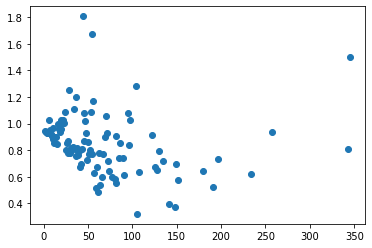

In [ ]:
# Evaluate RMSE by Number of Reviews
val = val.merge(val_rating_df,how='left',on=['user','item','overall'])
val['SE'] = (val['RNN'] - val['overall'])**2
r1 = val.groupby(by='n_reviews')[['SE']].mean().reset_index()
r1['RMSE'] = np.sqrt(r1['SE'])
plt.scatter(r1.n_reviews,r1.RMSE)

# Summary Flag Predictions

In [ ]:
def star_flags(dataframe):
    df = dataframe.copy()
    
    # Create Flags
    df['star_flag'] = df['summary_tokens'].apply(lambda x: int('star' in x or 'stars' in x))
    for n in [(1,'one'),(2,'two'),(3,'three'),(4,'four'),(5,'five')]:
        df['num_'+str(n[0])+'_flag'] = df['summary'].apply(lambda x: int(str(n[0])+' ' in x))
        df['word_'+str(n[0])+'_flag'] = df['summary_tokens'].apply(lambda x: int(n[1] in x))
        df['num_'+str(n[0])+'pt_flag'] = 0
        df.loc[df.summary.str.contains("["+str(n[0])+"]{1}([.][5]{1})"),'num_'+str(n[0])+'pt_flag'] = 1
    
    # Make Predictions
    predictions = [[],[],[],[],[]]
    for n in [(1,'one'),(2,'two'),(3,'three'),(4,'four'),(5,'five')]:
        for (i,star_flag,word_flag,num_flag,numpt_flag,num_5_flag,word_5_flag) in tqdm(df[['star_flag','word_'+str(n[0])+'_flag','num_'+str(n[0])+'_flag','num_'+str(n[0])+'pt_flag','num_5_flag','word_5_flag']].itertuples()):
            if ((star_flag == 1) and (word_flag == 1)) or ((star_flag == 1) and (word_flag == 1)) or ((star_flag == 1) and (numpt_flag == 1)):
                pred = n[0] 
            else:
                pred = 0
            predictions[n[0]-1].append(pred)
    df['star_max_pred'] = np.array(predictions).max(axis=0)
    #df['star_mean_pred'] = np.array(predictions).sum(axis=0) / (np.array(predictions)>0).sum(axis=0)
    #print(np.mean((gg.loc[gg.star_max_pred>0,'overall'] - gg.loc[gg.star_max_pred>0,'star_max_pred'])**2))
    #print(np.mean((gg.loc[gg.star_mean_pred>0,'overall'] - gg.loc[gg.star_mean_pred>0,'star_mean_pred'])**2)) 
    return df


# Classifier

In [ ]:
# Processing
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(pipeline.df.tokens,pipeline.df.overall,test_size=0.2,random_state=1)
X_train = train.tokens.values
y_train = train.overall.values
X_test = val.tokens.values
y_test = val.overall.values

In [ ]:
def dummy_fun(doc):
   return doc

topk = 3000

TF = CountVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_features=topk
)

TFIDF = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_features=topk
)

In [ ]:
load_lr_model = False

if load_lr_model == True:
    lr = pickle.load(open('lr_'+str(topk)+'.p','rb'))
    tf = TFIDF.fit(X_train) #TFIDF.fit(train.tokens.values)
    x_train = tf.transform(X_train) #tf.transform(train.tokens.values)
    #y_train = train.overall
    x_val = tf.transform(X_test) #tf.transform(val.tokens.values)
    y_val = y_test #val.overall
else:
    tf = TFIDF.fit(X_train)#TFIDF.fit(train.tokens.values)
    x_train = tf.transform(X_train)#tf.transform(train.tokens.values)
    #y_train = train.overall
    x_val = tf.transform(X_test)#tf.transform(val.tokens.values)
    y_val = y_test#val.overall
    lr = LogisticRegression(C=0.9,max_iter=5000,random_state=1)
    lr.fit(x_train,y_train)
    pickle.dump(lr,open('lr_'+str(topk)+'.p','wb'))

In [ ]:
print(np.mean((lr.predict(x_val) - y_val)**2))
print(np.mean((lr.predict(x_train) - y_train)**2))

0.7102333333333334
0.6390833333333333


# Ensemble

In [ ]:
# Load val dataframe with RNN preds
en = val.copy()
# Create LR preds
en['lr_pred'] = lr.predict(tf.transform(en.tokens.values)) 
# Create star flag preds
en = star_flags(en)
# Filter NULL RNN preds for eval
en = en.loc[~en.RNN.isna()].copy()

# Not as effective, but we can weight ensemble by number of reviews per user
#en['weight'] = (en['n_reviews'] - np.min(en['n_reviews'])) / (np.max(en['n_reviews'])-np.min(en['n_reviews']))
#en['pred'] = ((1-en['weight'])*en['lr_pred'] + (en['weight'])*en['RNN'])

# Make ensemble predictions
error = {}
for w1 in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    # Balance between LR and RNN
    en['pred_'+str(w1)] = ((1-w1)*en['lr_pred'] + (w1)*en['RNN'])
    error[str(w1)] = mean_squared_error(en.overall,en['pred_'+str(w1)])

    # If we have a star pred use star pred
    en.loc[en.star_max_pred > 0,'pred_'+str(w1)+"_star"] = en.loc[en.star_max_pred > 0,'star_max_pred']
    en.loc[en.star_max_pred==0,'pred_'+str(w1)+"_star"] = en.loc[en.star_max_pred==0,'pred_'+str(w1)]  
    
    # If we have a star pred, use a version weighting the star pred less than 100%
    w2_ = 1 - w1
    for w2 in np.arange(0,w2_,0.1)+0.1:
        en.loc[en.star_max_pred > 0,'pred_'+str(w1)+"_"+str(w2)] = (w1)*en.loc[en.star_max_pred > 0,'RNN'] + (w2_-w2)*en.loc[en.star_max_pred > 0,'lr_pred'] + (w2)*en.loc[en.star_max_pred > 0,'star_max_pred']
        en.loc[en.star_max_pred==0,'pred_'+str(w1)+"_"+str(w2)] = (w1)*en.loc[en.star_max_pred==0,'RNN'] + (w2_)*en.loc[en.star_max_pred==0,'lr_pred']
        if w1 + (w2_-w2) + w2 > 1.01:
            print("weights exceed 1")
            print((w1,w2_-w2,w2))
        error[str(w1)+"_"+str(w2)] = mean_squared_error(en.overall,en['pred_'+str(w1)+"_"+str(w2)])


#en.loc[en.star_flag > 0,'pred_star'] = en.loc[en.star_flag > 0,'star_max_pred']
#en.loc[en.star_max_pred==0,'pred_star'] = en.loc[en.star_max_pred==0,'pred_0.6']
#print((mean_squared_error(en.overall,en['pred_0.6']),mean_squared_error(en.overall,en['pred_star'])))

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
30000it [00:00, 381799.02it/s]
30000it [00:00, 463237.20it/s]
30000it [00:00, 435394.88it/s]
30000it [00:00, 344428.74it/s]
30000it [00:00, 421556.45it/s]


In [ ]:
min_error = pd.DataFrame.from_dict(error,orient='index').sort_values(by=0)

In [ ]:
min_error.head()

,0
0.4_0.5,0.599182
0.4_0.6,0.599312
0.4_0.4,0.599366
0.4_0.30000000000000004,0.599863
0.4_0.2,0.600673


In [ ]:
w1 = float(min_error.index[0].split("_")[0])
w2_ = 1 - w1
w2 = float(min_error.index[0].split("_")[1])
print((w1,w2_-w2,w2))

(0.4, 0.09999999999999998, 0.5)


# Test Data

In [ ]:
test = pd.read_csv("test.csv")
test_pipeline = Pipeline(test)
test_pipeline.run()
df_test = test_pipeline.df.copy()

In [ ]:
# Make RNN Pred
test_rating_df = test[['user','item']].copy()
test_rating_df['RNN'] = rs_model.predict([test_rating_df.user.values,test_rating_df.item.values])
# Make Star Flag Pred
df_test = star_flags(df_test)
# Make LR Pred
df_test['lr_pred'] = lr.predict(tf.transform(df_test.tokens.values))
# Merge Preds
df_test = df_test[['reviewerID','itemID','user','item','star_max_pred','lr_pred']].merge(test_rating_df,how='left',on=['user','item'])

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
20000it [00:00, 493354.66it/s]
20000it [00:00, 440270.61it/s]
20000it [00:00, 399975.59it/s]
20000it [00:00, 377943.54it/s]
20000it [00:00, 403304.28it/s]


In [ ]:
df_test.loc[df_test.star_max_pred > 0,'prediction'] = (w1)*df_test.loc[df_test.star_max_pred > 0,'RNN'] + (w2_-w2)*df_test.loc[df_test.star_max_pred > 0,'lr_pred'] + (w2)*df_test.loc[df_test.star_max_pred > 0,'star_max_pred']
df_test.loc[df_test.star_max_pred ==0,'prediction'] = (w1)*df_test.loc[df_test.star_max_pred ==0,'RNN'] + (w2_)*df_test.loc[df_test.star_max_pred ==0,'lr_pred']

In [ ]:
test = df_test[['reviewerID','itemID','prediction']].copy()

In [ ]:
test.head()

,reviewerID,itemID,prediction
0,u04140621,p65721979,4.867567
1,u74766187,p87809670,4.537337
2,u31689638,p52702240,4.783937
3,u35613516,p01314374,4.223151
4,u93320378,p84396269,4.643857


In [ ]:
test['userID-itemID'] = test['reviewerID']+"-"+test['itemID']

In [ ]:
rating_pairs = test[['userID-itemID','prediction']].copy()

In [ ]:
rating_pairs.to_csv("rating_pairs_submission4.csv",index=False)

In [ ]:
rating_pairs

,userID-itemID,prediction
0,u04140621-p65721979,4.867567
1,u74766187-p87809670,4.537337
2,u31689638-p52702240,4.783937
3,u35613516-p01314374,4.223151
4,u93320378-p84396269,4.643857
...,...,...
19995,u16765812-p17291597,4.882435
19996,u04428712-p73630774,4.871598
19997,u39251384-p58275451,4.872159
19998,u05089888-p13155723,4.804947


In [ ]:
pd.read_csv('rating_pairs.csv')

FileNotFoundError: ignored

# Archive

### Use vader to evaluated sentiment of reviews
def evalSentences(df,cols=['itemID','reviewText','sentiment','score']):
    sentences = df['reviewText'].values
    review = df[['itemID','reviewText','overall']].itertuples()
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pd_list = []
    for i in review:
        item,sentence,score = i[1],i[2],i[3]
        ss = sid.polarity_scores(sentence)
        pd_list.append((item,sentence,ss['compound'],score))
    reviewDf = pd.DataFrame(pd_list)
    reviewDf.columns = cols
    return reviewDf
sentiment = evalSentences(pipeline.df)
import matplotlib.pyplot as plt
plt.scatter(sentiment.score,sentiment.sentiment,alpha=0.01)

# Item-Item

class SimRecSys(object):
    def __init__(self, matrix, num_users, num_items, base, method):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.matrix = matrix
        self.num_users = num_users
        self.num_items = num_items
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
        
    def predict_all(self):
        train_matrix = self.matrix #self.processor(train_df, num_users, num_items)
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        if self.base == 'user':
            k = 50
            uu_sim = self.method(train_matrix)
            m,n = uu_sim.shape
            normalizer = np.matmul(uu_sim, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_sim, train_matrix)/normalizer
            # if no one has rated this item before, use user average  
            num_user_ratings = np.sum(temp_matrix, axis=1)
            num_user_ratings[num_user_ratings == 0] = 1e-5
            useraverage = np.sum(train_matrix, axis=1)/num_user_ratings
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            
        elif self.base == 'item':
            k = 50
            # Transpose matrix for item-item similarity scores
            uu_sim = self.method(train_matrix.T)
            m,n = uu_sim.shape
            normalizer = np.matmul(uu_sim, temp_matrix.T)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_sim, train_matrix.T)/normalizer 
            # if user has no ratings, use item average
            num_item_ratings = np.sum(temp_matrix.T, axis=1)
            num_item_ratings[num_item_ratings == 0] = 1e-5
            itemaverage = np.sum(train_matrix.T,axis=1)/num_item_ratings
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T
        else:
            print('No other option available')
    
    def reset(self):
        try:
            self.model = None
        except:
            print("You do not have model..")

train_pipeline = Pipeline(train)
train_pipeline.create_matrix()

user_cosine_recsys = SimRecSys(train_pipeline.matrix,num_user,num_item,'user','cosine')
item_cosine_recsys = SimRecSys(train_pipeline.matrix,num_user,num_item,'item','cosine')

In [ ]:
#user_cosine_recsys.predict_all()
#item_cosine_recsys.predict#_all()